<a href="https://colab.research.google.com/github/nrush23/Machine-Learning-2022/blob/main/Kouh_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pose Detection with OpenPose

This notebook uses an open source project [CMU-Perceptual-Computing-Lab/openpose](https://github.com/CMU-Perceptual-Computing-Lab/openpose.git) to detect/track multi person poses on a given youtube video.

For other deep-learning Colab notebooks, visit [tugstugi/dl-colab-notebooks](https://github.com/tugstugi/dl-colab-notebooks).


## Install OpenPose

In [1]:
import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/CMU-Perceptual-Computing-Lab/openpose.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # see: https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/949
  # install new CMake becaue of CUDA10
  !wget -q https://cmake.org/files/v3.13/cmake-3.13.0-Linux-x86_64.tar.gz
  !tar xfz cmake-3.13.0-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local
  # clone openpose
  !git clone -q --depth 1 $git_repo_url
  !sed -i 's/execute_process(COMMAND git checkout master WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/execute_process(COMMAND git checkout f019d0dfe86f49d1140961f8c7dec22130c83154 WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/g' openpose/CMakeLists.txt
  # install system dependencies
  !apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev
  # install python dependencies
  #!pip install -q youtube-dl
  # build openpose
  !cd openpose && rm -rf build || true && mkdir build && cd build && cmake .. && make -j`nproc`
  
from IPython.display import YouTubeVideo

Selecting previously unselected package libgflags2.2.
(Reading database ... 155653 files and directories currently installed.)
Preparing to unpack .../00-libgflags2.2_2.2.1-1_amd64.deb ...
Unpacking libgflags2.2 (2.2.1-1) ...
Selecting previously unselected package libgflags-dev.
Preparing to unpack .../01-libgflags-dev_2.2.1-1_amd64.deb ...
Unpacking libgflags-dev (2.2.1-1) ...
Selecting previously unselected package libgoogle-glog0v5.
Preparing to unpack .../02-libgoogle-glog0v5_0.3.5-1_amd64.deb ...
Unpacking libgoogle-glog0v5 (0.3.5-1) ...
Selecting previously unselected package libgoogle-glog-dev.
Preparing to unpack .../03-libgoogle-glog-dev_0.3.5-1_amd64.deb ...
Unpacking libgoogle-glog-dev (0.3.5-1) ...
Selecting previously unselected package libhdf5-serial-dev.
Preparing to unpack .../04-libhdf5-serial-dev_1.10.0-patch1+docs-4_all.deb ...
Unpacking libhdf5-serial-dev (1.10.0-patch1+docs-4) ...
Selecting previously unselected package libleveldb1v5:amd64.
Preparing to unpack ...

## Detect poses on a test video

We are going to detect poses on the following youtube video:

Download the above youtube video, cut the first 5 seconds and do the pose detection on that 5 seconds:

In [11]:
#!rm -rf youtube.mp4
# download the youtube with the given ID
#!youtube-dl -f 'bestvideo[ext=mp4]' --output "youtube.%(ext)s" https://www.youtube.com/watch?v=$YOUTUBE_ID
# cut the first 5 seconds
#!ffmpeg -y -loglevel info -i youtube.mp4 -t 5 video.mp4
# detect poses on the these 5 seconds
!rm openpose.avi
!cd openpose && ./build/examples/openpose/openpose.bin --video ../video6.mp4 --write_json ./output/ --display 0  --write_video ../openpose.avi
# convert the result into MP4
!ffmpeg -y -loglevel info -i openpose.avi output.mp4

Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
OpenPose demo successfully finished. Total time: 30.188602 seconds.
ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-lib

In [12]:
#I use these commands to zip and download the openpose output after it
#processes my videos
!zip -r /content/file.zip /content/openpose/output
from google.colab import files
files.download("/content/file.zip")

updating: content/openpose/output/ (stored 0%)
  adding: content/openpose/output/video6_000000000125_keypoints.json (deflated 61%)
  adding: content/openpose/output/video6_000000000351_keypoints.json (stored 0%)
  adding: content/openpose/output/video6_000000000146_keypoints.json (deflated 50%)
  adding: content/openpose/output/video6_000000000150_keypoints.json (deflated 51%)
  adding: content/openpose/output/video6_000000000235_keypoints.json (deflated 51%)
  adding: content/openpose/output/video6_000000000174_keypoints.json (deflated 51%)
  adding: content/openpose/output/video6_000000000253_keypoints.json (deflated 52%)
  adding: content/openpose/output/video6_000000000335_keypoints.json (stored 0%)
  adding: content/openpose/output/video6_000000000143_keypoints.json (deflated 50%)
  adding: content/openpose/output/video6_000000000307_keypoints.json (stored 0%)
  adding: content/openpose/output/video6_000000000040_keypoints.json (stored 0%)
  adding: content/openpose/output/video6_

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
import os
from os.path import exists, join, basename, splitext

#function to delete files in my output folder after I finish running them
def deleteFiles():
  rawFiles = os.listdir('/content/openpose/output')
  for file in rawFiles:
    os.remove('/content/openpose/output/' + file)

def deleteFiles2(path):
  rawFiles = os.listdir('/content/testFolder')
  for file in rawFiles:
    os.remove(path + '/' + file)

deleteFiles2('/content/testFolder')

IsADirectoryError: ignored

In [63]:
#I unzip my openpose files because I didn't set up a pathway to my google drive
!unzip /content/output.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/OpenPose Sample Output/Em3_000000000321_keypoints.json  
  inflating: /content/OpenPose Sample Output/Em3_000000000029_keypoints.json  
  inflating: /content/OpenPose Sample Output/Em1_000000000066_keypoints.json  
  inflating: /content/OpenPose Sample Output/Kayla2_000000000318_keypoints.json  
  inflating: /content/OpenPose Sample Output/Em2_000000000246_keypoints.json  
  inflating: /content/OpenPose Sample Output/Jai7_000000000191_keypoints.json  
  inflating: /content/OpenPose Sample Output/Em4_000000000204_keypoints.json  
  inflating: /content/OpenPose Sample Output/Jai8_000000000081_keypoints.json  
  inflating: /content/OpenPose Sample Output/Em2_000000000290_keypoints.json  
  inflating: /content/OpenPose Sample Output/Em4_000000000393_keypoints.json  
  inflating: /content/OpenPose Sample Output/Em4_000000000206_keypoints.json  
  inflating: /content/OpenPose Sample Output/Ashita1_000000000652_keypoints

<h1>Here are my functions after I've worked on them for a while. The original ones I started with are below these 2 cells</h1>

In [64]:
import os
from os.path import exists, join, basename, splitext
import json
import matplotlib.pyplot as plt

data = [];

#this is my default output path because I unzip my raw jsons.
#Takes all the jsons and puts them into one data array to be
#accessed in getCoord()
def sortFiles():
  rawFiles = os.listdir('/content/OpenPose Sample Output')
  rawFiles.sort()
  for file in rawFiles:
    openFile = open('/content/OpenPose Sample Output/' + file)
    data.append(json.load(openFile))
    openFile.close()

def sortFiles2(fileName):
  rawFiles = os.listdir('/content/OpenPose Sample Output')
  rawFiles.sort()
  for file in rawFiles:
    if fileName in file:
      openFile = open('/content/OpenPose Sample Output/' + file)
      temp = json.load(openFile)
      if len(temp['people']) == 0:
        temp = {'version': 1.3, 'people':[{'person_id': [-1], 'pose_keypoints_2d':[0]*75}]}
      data.append(temp)
      # data.append(json.load(openFile))
      openFile.close()

#the function that actually lets us retrieve our coordinate values
#I realized the pattern for accessing a specific keypoint's coordinate is
#array position = ((keypoint - 1) * 3) + (0 or 1 depending on if it's x or y)
def getCoord(frame, keypoint, coord):
  if coord == 'x':
    coord = 0
  else:
    coord = 1
  return data[frame]['people'][0]['pose_keypoints_2d'][(keypoint - 1) * 3 + coord]


#if you need a specific keypoint array, use this function to get those keypoints.
#You specify which frames to start and end at, function is inclusive
def getKpArray(frameStart, frameEnd, keypoint):
  kp=[];
  for frame in range(frameStart, frameEnd + 1):
    kp.append(getCoord(frame, keypoint, 'x'))
    kp.append(getCoord(frame, keypoint, 'y'))
  return kp


#gets all the x and y coordinates so that we can make a scatterplot
#offsets the x value by 800 per frame so the sticks aren't on top
#of eachother. The y is negative because the stick figures were upside down
def displayGraph(frameStart, frameEnd):
  xCords=[]
  yCords=[]
  for frame in range(frameStart, frameEnd + 1):
    for kp in range(0,26):
      xCords.append(getCoord(frame,kp,'x') + frame * 800)
      yCords.append(-getCoord(frame,kp,'y'))
  plt.scatter(xCords, yCords)
  plt.show()
  

sortFiles2('Ashita2_')
  

In [59]:
print(len(data))

782


In [73]:
import csv
# sortFiles2()
def getCSV():
  file = open('/content/empty.csv', 'w')
  writer = csv.writer(file)
  row = ['Frame']
  for num in range(1,26):
    row.append('x' + str(num))
    row.append('y' + str(num))
  writer.writerow(row)
  for x in range (0, len(data)):
    row = [x]
    for kp in range (1,26):
      row.append(getCoord(x,kp,'x'))
      row.append(getCoord(x,kp,'y'))
    writer.writerow(row)
  file.close()

getCSV()


In [78]:
from google.colab import files
sortFiles2('Jai1')
getCSV()
data.clear()
files.download('empty.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [71]:
data.clear()
print(data)

[]


In [54]:
row = {'version': 1.3, 'people':[{'person_id': [-1], 'pose_keypoints_2d':[0]*50}]}
print(row)
print(data[0])

{'version': 1.3, 'people': [{'person_id': [-1], 'pose_keypoints_2d': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}]}
{'version': 1.3, 'people': [{'person_id': [-1], 'pose_keypoints_2d': [649.467, 185.534, 0.776622, 702.936, 183.003, 0.644995, 704.273, 246.817, 0.622426, 801.966, 275.467, 0.240897, 910.129, 278.101, 0.101839, 710.734, 128.218, 0.644928, 822.809, 120.364, 0.391462, 916.665, 115.17, 0.551438, 887.977, 166.01, 0.156632, 897.096, 160.792, 0.171542, 972.683, 154.277, 0.118062, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 636.481, 199.904, 0.727467, 640.322, 172.589, 0.805134, 640.375, 218.149, 0.345702, 644.296, 153.007, 0.495146, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'face_keypoints_2d': [], 'hand_left_keypoints_2d': [], 'hand_right_keypoints_2d': [], 'pose_keypoints_3d': [], 'face_keypoints_3d': [], 'hand_left_keypoints_3d': [], 'hand_right_keypoints_3d': []}]}

In [31]:
import csv

file = open('/content/test.csv', 'w')
writer = csv.writer(file)
writer.writerow(data)
file.close()

In [24]:
kp1 = getKpArray(0,len(data)-1,1)

for x in range (0, len(kp1), 2):
  print(kp1[x])

649.467
646.861
648.208
648.185
648.181
649.446
650.734
650.758
650.747
650.838
650.818
650.786
650.819
650.774
650.779
650.811
652.071
652.15
652.127
659.878
659.924
658.63
661.247
661.226
662.548
663.811
666.432
665.163
667.728
670.33
670.312
670.323
669.034
669.033
671.616
671.646
671.673
672.946
674.261
673.009
673.006
672.914
672.978
674.292
674.281
676.855
676.874
682.062
683.425
688.579
691.193
685.979
691.214
692.453
691.216
695.11
696.404
699.014
701.624
704.179
704.284
708.144
710.721
713.296
713.359
713.373
714.613
715.961
717.279
721.181
722.45
722.457
723.763
723.769
725.118
726.4
726.415
726.388
727.68
730.267
730.277
731.58
732.886
727.693
730.284
708.128
734.14
734.212
734.199
735.512
736.782
735.495
735.464
735.463
735.547
734.229
735.496
734.192
735.546
739.404
735.491
736.791
738.136
702.906
704.177
713.348
708.122
0
734.185
734.198
727.665
727.673
728.988
723.821
723.753
723.741
704.24
721.156
718.559
714.624
714.643
714.695
714.646
714.655
715.988
715.972
684.7
717

In [13]:
import os
from os.path import exists, join, basename, splitext
import json
import matplotlib.pyplot as plt

data = [];

def sortFiles2():
  kp = []
  rawFiles = os.listdir('/content/ashitaFiles')
  rawFiles.sort()
  for file in rawFiles:
    openFile = open('/content/ashitaFiles/' + file)
    data = json.load(openFile)
    # print(data['people'][0]['pose_keypoints_2d'][0])
      # pair.append(data['people'][0]['pose_keypoints_2d'][((keypoint - 1) * 3)])
      # pair.append(data['people'][0]['pose_keypoints_2d'][((keypoint - 1) * 3 + 1)])
      # kp.append(pair)
    openFile.close()
  # return kp


# kp1 = sortFiles2()

# print(kp1)

# sortFiles2()
print(data['people'])

649.467
646.861
648.208
648.185
648.181
649.446
650.734
650.758
650.747
650.838
650.818
650.786
650.819
650.774
650.779
650.811
652.071
652.15
652.127
659.878
659.924
658.63
661.247
661.226
662.548
663.811
666.432
665.163
667.728
670.33
670.312
670.323
669.034
669.033
671.616
671.646
671.673
672.946
674.261
673.009
673.006
672.914
672.978
674.292
674.281
676.855
676.874
682.062
683.425
688.579
691.193
685.979
691.214
692.453
691.216
695.11
696.404
699.014
701.624
704.179
704.284
708.144
710.721
713.296
713.359
713.373
714.613
715.961
717.279
721.181
722.45
722.457
723.763
723.769
725.118
726.4
726.415
726.388
727.68
730.267
730.277
731.58
732.886
727.693
730.284
708.128
734.14
734.212
734.199
735.512
736.782
735.495
735.464
735.463
735.547
734.229
735.496
734.192
735.546
739.404
735.491
736.791
738.136
702.906
704.177
713.348
708.122
0
734.185
734.198
727.665
727.673
728.988
723.821
723.753
723.741
704.24
721.156
718.559
714.624
714.643
714.695
714.646
714.655
715.988
715.972
684.7
717

IndexError: ignored

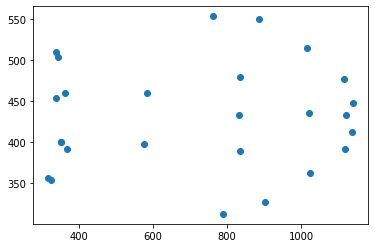

1121.97


In [42]:
sortFiles()

displayGraph(0,0)

print(getCoord(0,1,'x'))

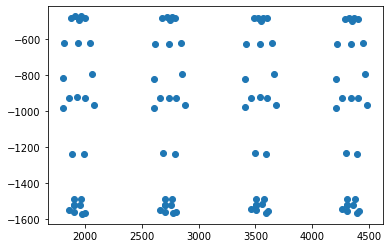

In [ ]:
import matplotlib.pyplot as plt


#gets all the x and y coordinates so that we can make a scatterplot
#offsets the x value by 800 per frame so the sticks aren't on top
#of eachother. The y is negative because the stick figures were upside down
def displayGraph(frameStart, frameEnd):
  xCords=[]
  yCords=[]
  for frame in range(frameStart, frameEnd + 1):
    for kp in range(0,26):
      xCords.append(getCoord(frame,kp,'x') + frame * 800)
      yCords.append(-getCoord(frame,kp,'y'))
  plt.scatter(xCords, yCords)
  plt.show()

displayGraph(0,3)


<h1>Previous code I was working with </h1>

In [ ]:
import os
from os.path import exists, join, basename, splitext
import json 


#in future someone can research into making 2d array for python
#or focus on using that getCoord() function
kp1=[];
kp2=[];
kp3=[];
kp4=[];
kp5=[];
kp6=[];
kp7=[];
kp8=[];
kp9=[];
kp10=[];
kp11=[];
kp12=[];
kp13=[];
kp14=[];
kp15=[];
kp16=[];
kp17=[];
kp18=[];
kp19=[];
kp20=[];
kp21=[];
kp22=[];
kp23=[];
kp24=[];
allKps=[kp1,kp2,kp3,kp4,kp5,kp6,kp7,kp8,kp9,kp10,kp11,kp12,kp13,kp14,kp15,kp16,kp17,kp18,kp19,kp20,kp21,kp22,kp23,kp24]

data = [];

#for future work, we could retrieve coordinates on the fly like this
#rather than filter them into individual arrays
def getCoordWIP(frame, keypoint, coord):
  return data['people'][0]['pose_keypoints_2d'][frame][keypoint][coord]


#original file sort function that got the data from the jsons
def sortFilesOg():
  rawFiles = os.listdir('/content/content/openpose/output')
  rawFiles.sort()
  for file in rawFiles:
    openFile = open('/content/output/content/openpose/output/' + file)
    rawData = json.load(openFile)
    data.append(rawData['people'][0]['pose_keypoints_2d'])
    openFile.close()

#function that cycles through a list of files and adds their key points to the individual key point arrays
def setKp(data):
    for frame in range(0, len(data)):
      position = 0
      for kp in allKps:
        kp.append(data[frame][position:position + 2])
        position += 3





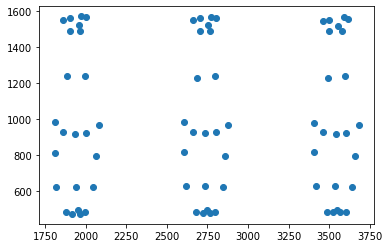

In [ ]:
import matplotlib.pyplot as plt


#displays the points from the 0th frame to the one you specify

def displayGraphOg(frames):
  xCords=[];
  yCords=[];  
  for frame in range(0, frames):
    for kp in allKps:
      xCords.append(kp[frame][0] + frame * 800)
      yCords.append(kp[frame][1])
  plt.scatter(xCords, yCords)
  plt.show()

displayGraphOg(3)


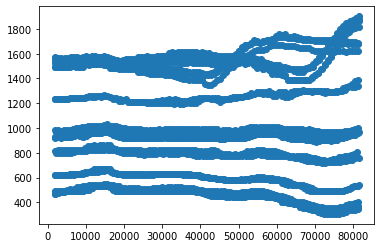

In [ ]:
displayGraph(100)

Finally, visualize the result:

In [ ]:
def show_local_mp4_video(file_name, width=640, height=480):
  import io
  import base64
  from IPython.display import HTML
  video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
  return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
                        <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                      </video>'''.format(width, height, video_encoded.decode('ascii')))

show_local_mp4_video('output.mp4', width=960, height=720)